In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def generate_random_dot_image(width, height, min_dots, max_dots, dot_size):
  num_dots = np.random.randint(min_dots, max_dots + 1)

  # Creates an array of the given shape filled with zeros (black)
  black_image = np.zeros((height, width), dtype=np.uint8)

  # Generate arrays of random x and y coordinates for the top-left corner of each dot
  random_x = np.random.randint(0, width - dot_size + 1, num_dots)
  random_y = np.random.randint(0, height - dot_size + 1, num_dots)

  # Iterates over each pair of (x, y) coordinates. For each dot, it sets a square region of the image (dot_size) to the pixel value 155
  # 155 corresponds to a mid-range gray on a scale of 0 (black) to 255 (white), so each dot will appear gray against the black background
  for x, y in zip(random_x, random_y):
    black_image[y:y + dot_size, x:x + dot_size] = 155

  # print(f"\nblack_image: {black_image}")

  return black_image

In [ ]:
def generate_random_rings_image(width, height, min_rings, max_rings, thicc):
    white_image = np.full((height, width), 255, dtype=np.uint8)  # White background

    center_x, center_y = width // 2, height // 2  # Center of the image

    # Randomly chooses the number of rings to generate
    num_rings = np.random.randint(min_rings, max_rings + 1)

    # Generates random radii for each ring, constrained between 1/20th and 1/3rd of the smaller dimension of the image, ensuring that rings fit within the image frame
    radii = np.random.randint(min(width, height) // 20, min(width, height) // 3, size=num_rings)

    # Sorts and then reverses the list of radii, so rings are drawn from the largest to the smallest. This ensures that smaller rings are not obscured by larger ones when drawn
    radii.sort()  # Sort radii in ascending order
    radii = radii[::-1]  # Reverse to start drawing from largest to smallest

    # Iterates over each radius, calculating the outer_radius and inner_radius of each ring. The inner radius is adjusted by the thicc parameter to create the thickness of the ring
    for radius in radii:
        outer_radius = radius
        inner_radius = max(outer_radius - thicc, 0)  # Ensure non-negative radius

        # Computes boolean masks for the outer and inner boundaries of each ring
        # The outer mask is where the circle pixels will be black, and the inner mask is where the circle pixels revert to white, forming the hollow part of each ring
        # Uses the masks to set the appropriate pixels in white_image. The outer ring area is set to black (0), and the inner ring area is set back to white (255), effectively drawing hollow rings
        y_indices, x_indices = np.ogrid[:height, :width]
        mask_outer = (x_indices - center_x)**2 + (y_indices - center_y)**2 <= outer_radius**2
        mask_inner = (x_indices - center_x)**2 + (y_indices - center_y)**2 < inner_radius**2

        white_image[mask_outer] = 0  # Black outer circle
        white_image[mask_inner] = 255  # White inner circle (hollow interior)

    return white_image

In [ ]:
def generate_random_square_image(width, height, min_squares, max_squares, thicc=1):
    white_image = np.full((height, width), 255, dtype=np.uint8)  # White background

    center_x, center_y = width // 2, height // 2  # Center of the image

    # Randomly chooses the number of rings to generate
    num_squares = np.random.randint(min_squares, max_squares + 1)

    # Generates random size for each square, constrained between 1/20th and 1/2nd of the smaller dimension of the image
    square_sizes = np.random.randint(min(width, height) // 20, min(width, height) // 2, size=num_squares)

    # print(f"num_squares: {num_squares}")

    # Sorts and then reverses the list of square_sizes, so squares are drawn from the largest to the smallest.
    # This ensures that smaller rings are not obscured by larger ones when drawn
    square_sizes.sort()  # Sort square_sizes in ascending order
    square_sizes = square_sizes[::-1]  # Reverse to start drawing from largest to smallest

    # Iterates over each square_sizes, calculating the outer_size and inner_size of each square.
    # The inner_size is adjusted by the thicc parameter to create the thickness of the square
    for size in square_sizes:
        outer_size = size
        inner_size = max(outer_size - thicc, 0)  # Ensure non-negative size
        # print(f"outer_size: {outer_size} inner_size: {inner_size}")

        # Define mask for outer square
        mask_outer = (np.abs(np.arange(height).reshape(-1, 1) - center_y) <= outer_size / 2) & \
                     (np.abs(np.arange(width).reshape(1, -1) - center_x) <= outer_size / 2)

        #true_indices = np.where(mask_outer)
        #print("Indices where mask_outer is True:", true_indices)

        # Define mask for inner square (hollow part)
        mask_inner = (np.abs(np.arange(height).reshape(-1, 1) - center_y) <= (inner_size-1) / 2) & \
                     (np.abs(np.arange(width).reshape(1, -1) - center_x) <= (inner_size-1) / 2)

        #true_indices = np.where(mask_inner)
        #print("Indices where mask_inner is True:", true_indices)

        white_image[mask_outer] = 0  # Black outer circle
        white_image[mask_inner] = 255  # White inner circle (hollow interior)

    return white_image

In [ ]:
def Plot(x, size, p, type = False):
    plt.figure(figsize=(10,size//5*2))
    for i in range(size):  # Display and save the first 5 separated images for rings and dots
      plt.subplot(size//5, 5, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      if type:
        plt.imshow(x[i], cmap=plt.cm.binary)
      else:
        plt.imshow(x[i], cmap='gray', vmin=0, vmax=1)
      #plt.imshow(x[i].reshape((height, width)), cmap='gray', vmin=0, vmax=255)
      plt.axis('off')
      plt.savefig(f"conv_separated_rings_image_{i}.png")
    plt.show()

In [ ]:
dataset_size = 1000 # 100
test_dataset_size = 1000 # 20
min_dots, max_dots = 20, 30
# width, height = 200, 200 # reduce size from 800, 800
# dot_size = 2 # 5 is original size for 800, 800
# thicc = 1 # 5.5 is the original thickness for 800, 800
width, height = 800, 800
dot_size = 5
thicc = 5.5

dataset_dots = np.zeros((dataset_size, height, width), dtype=np.uint8) # black
dataset_rings = np.zeros((dataset_size, height, width), dtype=np.uint8) # black
dataset_squares = np.zeros((dataset_size, height, width), dtype=np.uint8) # black

test_dataset_dots = np.zeros((test_dataset_size, height, width), dtype=np.uint8) # black
test_dataset_rings = np.zeros((test_dataset_size, height, width), dtype=np.uint8) # black
test_dataset_squares = np.zeros((dataset_size, height, width), dtype=np.uint8) # black

In [ ]:
for i in range(dataset_size):
  random_dots_image = generate_random_dot_image(width, height, min_dots, max_dots, dot_size)
  dataset_dots[i] = random_dots_image # black image with grey dots (0 is black, 255 is white)

  random_ring_image = generate_random_rings_image(width, height, 1, 3, thicc)
  dataset_rings[i] = random_ring_image # white image with black rings (0 is black, 255 is white)

  random_square_image = generate_random_square_image(width, height, 1, 3, thicc)
  dataset_squares[i] = random_square_image # white image with black rings (0 is black, 255 is white)

for i in range(test_dataset_size):
  random_dots_image = generate_random_dot_image(width, height, min_dots, max_dots, dot_size)
  test_dataset_dots[i] = random_dots_image # black image with grey dots (0 is black, 255 is white)

  random_ring_image = generate_random_rings_image(width, height, 1, 3, thicc)
  test_dataset_rings[i] = random_ring_image # white image with black rings (0 is black, 255 is white)

  random_square_image = generate_random_square_image(width, height, 1, 3, thicc)
  test_dataset_squares[i] = random_square_image # white image with black rings (0 is black, 255 is white)


In [ ]:
# print(f"\ndataset_rings before: {dataset_rings[10]}")
# dataset_rings_normalized = 255 - dataset_rings # not necessary
dataset_rings_normalized = dataset_rings / 255.0

# print(f"\ndataset_squares before: {dataset_squares[10]}")
dataset_squares_normalized = dataset_squares / 255.0

# print(f"\ndataset_rings: {dataset_rings[0]}, \ndataset_rings_normalized: {dataset_rings_normalized[0]}")
# print(f"\ndataset_dots before: {dataset_dots[0]}")
dataset_dots = 255 - dataset_dots # white image with grey dots
dataset_dots_normalized = dataset_dots / 255.0
# print(f"\ndataset_dots: {dataset_dots[0]}, \ndataset_dots_normalized: {dataset_dots_normalized[0]}")

test_dataset_rings_normalized = test_dataset_rings / 255.0
test_dataset_squares_normalized = test_dataset_squares / 255.0

test_dataset_dots = 255 - test_dataset_dots # white image with grey dots
test_dataset_dots_normalized = test_dataset_dots / 255.0

# Normalize the images and reshape them to (num_samples, height, width, channels) - NOT USED
# dataset_ring_dot = np.clip(dataset_rings + dataset_dots, 0, 255)
# dataset_ring_dot_norm = dataset_ring_dot.astype('float32') / 255.0
# dataset_ring_dot_reshaped = dataset_ring_dot_norm.reshape((-1, height, width, 1))

# Normalize the images and reshape them to (num_samples, height, width, channels) - NOT USED
# dataset_square_dot = np.clip(dataset_squares + dataset_dots, 0, 255)
# dataset_square_dot_norm = dataset_square_dot.astype('float32') / 255.0
# dataset_square_dot_reshaped = dataset_square_dot_norm.reshape((-1, height, width, 1))

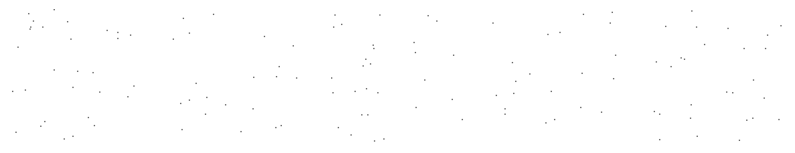

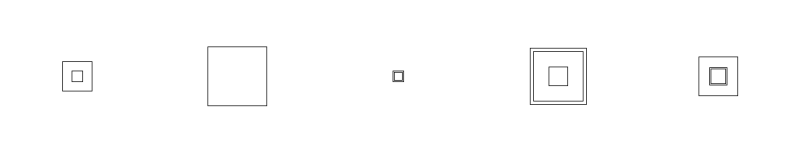

In [ ]:
# Visualize and save some of the separated images
# Plot(dataset_rings_normalized, 5, None)
Plot(dataset_dots_normalized, 5, None)
Plot(dataset_squares_normalized, 5, None)

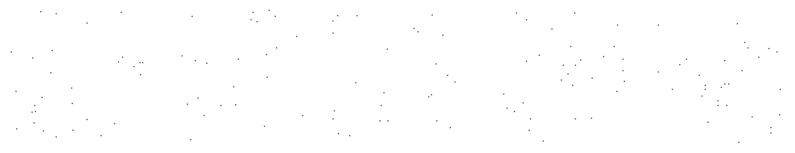

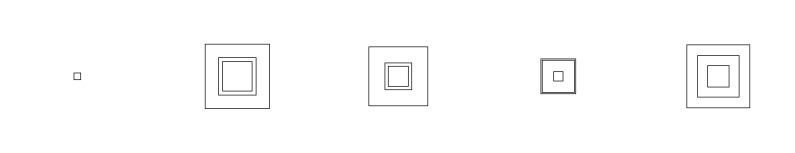

In [ ]:
# Visualize and save some of the separated images for test
# Plot(test_dataset_rings_normalized, 5, None)
Plot(test_dataset_dots_normalized, 5, None)
Plot(test_dataset_squares_normalized, 5, None)

In [ ]:
def overlay_images(base_image, overlay_image):
  # Where the overlay image is not white (255), overwrite the base image
  combined_image = np.where(overlay_image < 255, overlay_image, base_image)
  return combined_image

# Create a new dataset for the combined images
dataset_combined = np.zeros_like(dataset_dots)
test_dataset_combined = np.zeros_like(test_dataset_dots)

# Combine the dot and ring images
for i in range(dataset_size):
    dataset_combined[i] = overlay_images(dataset_dots[i], dataset_squares[i])
    # dataset_combined[i] = overlay_images(dataset_dots[i], dataset_rings[i])

# Normalize and reshape the combined dataset
dataset_combined_norm = dataset_combined.astype('float32') / 255.0
dataset_combined_reshaped = dataset_combined_norm.reshape((-1, height, width, 1))

# Combine the dot and ring images for tests
for i in range(test_dataset_size):
    test_dataset_combined[i] = overlay_images(test_dataset_dots[i], test_dataset_squares[i])
    # test_dataset_combined[i] = overlay_images(test_dataset_dots[i], test_dataset_rings[i])

# Normalize and reshape the combined dataset
test_dataset_combined_norm = test_dataset_combined.astype('float32') / 255.0
test_dataset_combined_reshaped = test_dataset_combined_norm.reshape((-1, height, width, 1))

#print(f"\ndataset_dots_normalized: {dataset_dots_normalized[0]}")
#print(f"\ndataset_combined: {dataset_combined[0]}")
#print(f"\ndataset_combined_norm: {dataset_combined_norm[0]}")
#print(f"\ndataset_combined_reshaped: {dataset_combined_reshaped[0]}")

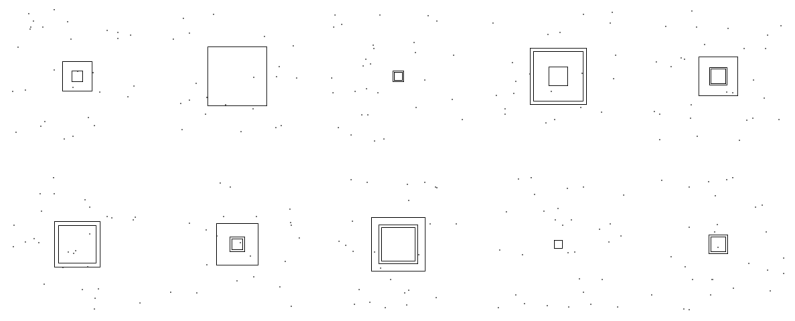

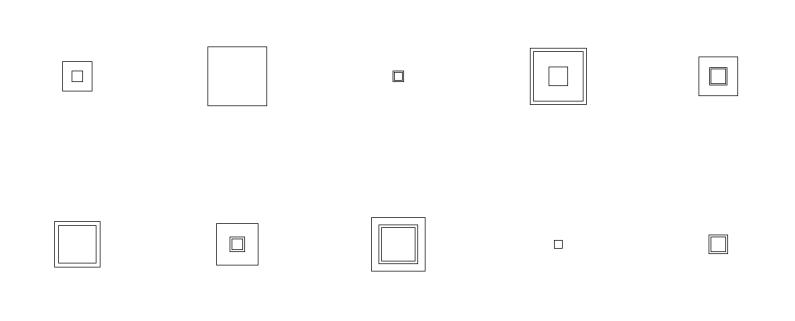

In [ ]:
# Display and save the first 10 combined images
Plot(dataset_combined_norm, 10, None)
Plot(dataset_squares_normalized, 10, None)
# Plot(dataset_rings_normalized, 10, None)

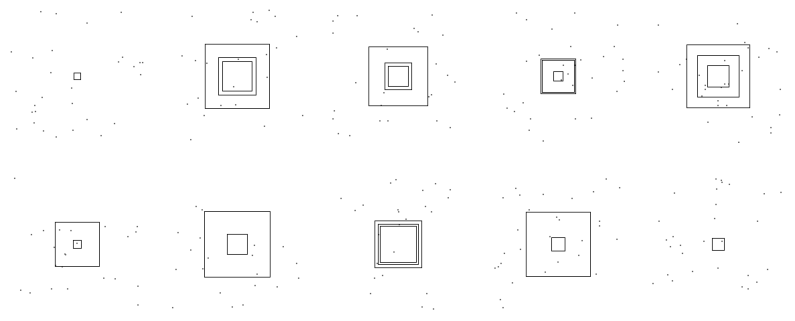

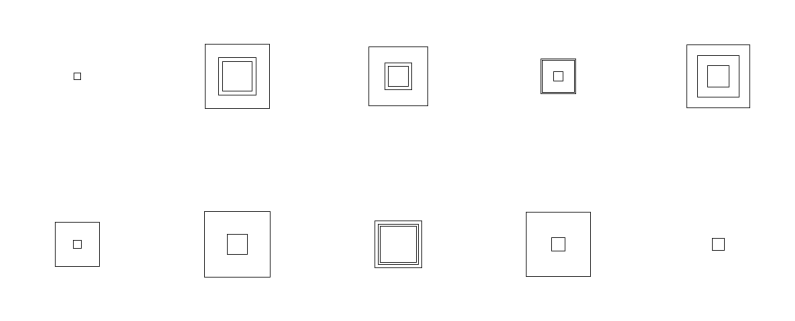

In [ ]:
# Display and save the first 10 combined images for test
Plot(test_dataset_combined_norm, 10, None)
Plot(test_dataset_squares_normalized, 10, None)
# Plot(test_dataset_rings_normalized, 10, None)

In [ ]:
print(f"Plotting original dataset_combined_norm")
print(f"dataset_combined_norm.shape: {dataset_combined_norm.shape} len(dataset_combined_norm): {len(dataset_combined_norm)}")
print(f"dataset_combined_norm[0].size: {dataset_combined_norm[0].size} dataset_combined_norm[0].shape: {dataset_combined_norm[0].shape}")

print(f"Plotting original dataset_squares_normalized")
print(f"dataset_squares_normalized.shape: {dataset_squares_normalized.shape} len(dataset_squares_normalized): {len(dataset_squares_normalized)}")
print(f"dataset_squares_normalized[0].size: {dataset_squares_normalized[0].size} dataset_squares_normalized[0].shape: {dataset_squares_normalized[0].shape}")

print(dataset_combined_norm.reshape((-1, height, width, 1)).shape)
print(dataset_squares_normalized.reshape((-1, height, width, 1)).shape)

dataset_squares_normalized = dataset_squares_normalized[:len(dataset_combined_norm)]

print(dataset_combined_norm.reshape((-1, height, width, 1)).shape)
print(dataset_squares_normalized.reshape((-1, height, width, 1)).shape)


Plotting original dataset_combined_norm
dataset_combined_norm.shape: (1000, 200, 200) len(dataset_combined_norm): 1000
dataset_combined_norm[0].size: 40000 dataset_combined_norm[0].shape: (200, 200)
Plotting original dataset_squares_normalized
dataset_squares_normalized.shape: (1000, 200, 200) len(dataset_squares_normalized): 1000
dataset_squares_normalized[0].size: 40000 dataset_squares_normalized[0].shape: (200, 200)
(1000, 200, 200, 1)
(1000, 200, 200, 1)
(1000, 200, 200, 1)
(1000, 200, 200, 1)


In [ ]:
# Convolutional Autoencoder architecture
input_img = Input(shape=(height, width, 1))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Training the autoencoder
# autoencoder.fit(dataset_combined_reshaped, target_dataset, epochs=50, batch_size=32)
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder.fit(dataset_combined_norm.reshape((-1, height, width, 1)),    # input data with noise (rings+dots)
                dataset_squares_normalized.reshape((-1, height, width, 1)), # ouput data without noise (rings)
                epochs=50, # 50 complete pass through the entire training dataset
                batch_size=10, # 32 number of samples that will be propagated through the network in one forward/backward pass
                validation_data = (test_dataset_combined_norm.reshape((-1, height, width, 1)),
                                   test_dataset_squares_normalized.reshape((-1, height, width, 1))), # evaluate the model's performance at the end of each epoch
                callbacks=[early_stopping])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 813ms/step - loss: 0.3756 - val_loss: 0.0617
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 75s 748ms/step - loss: 0.0569 - val_loss: 0.0292
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 744ms/step - loss: 0.0263 - val_loss: 0.0194
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 727ms/step - loss: 0.0188 - val_loss: 0.0153
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 853ms/step - loss: 0.0149 - val_loss: 0.0124
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 134s 777ms/step - loss: 0.0122 - val_loss: 0.0111
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 730ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 800ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 775ms/step - loss: 0.0068 - val_loss: 0.0048
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 770ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 765ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 12/50
100/10

200x200 20 epochs batch size = 10 performance

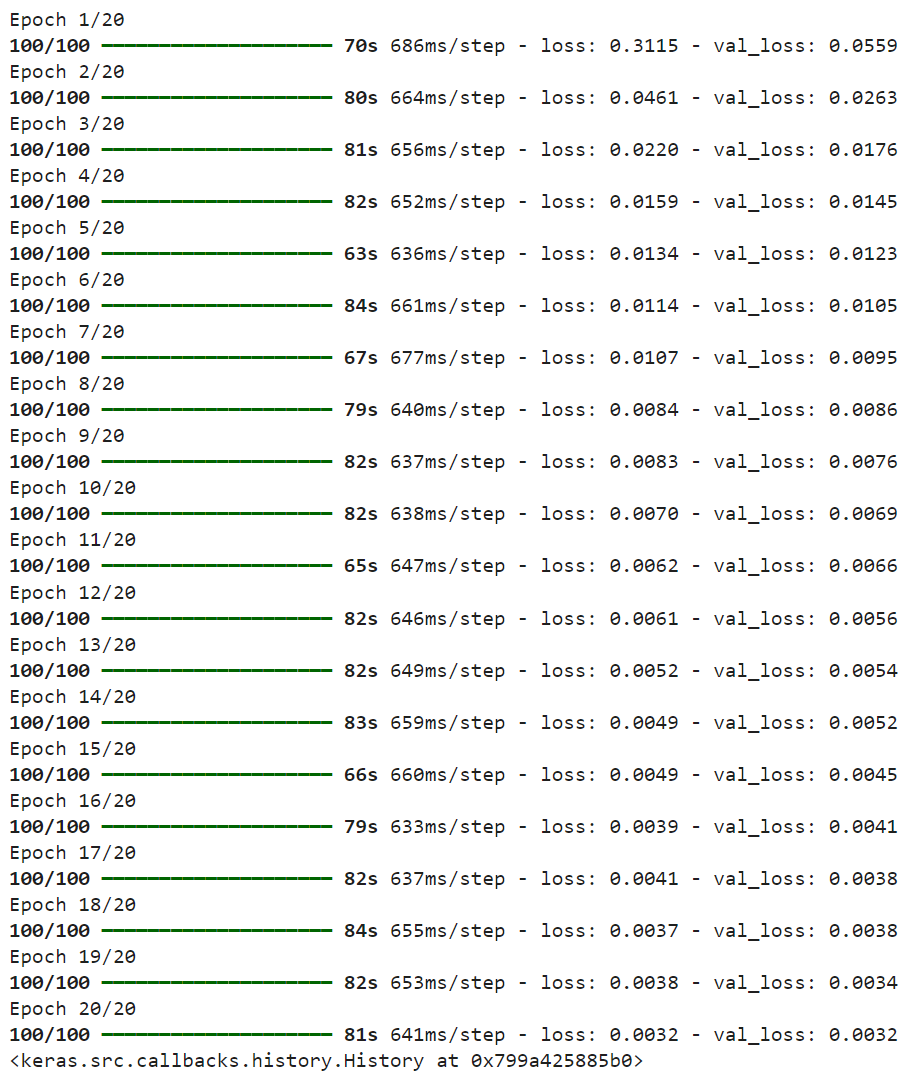

In [ ]:
# Use the trained autoencoder to decode the combined images
evaluation = autoencoder.evaluate(test_dataset_combined_norm.reshape((-1, height, width, 1)), test_dataset_squares_normalized.reshape((-1, height, width, 1)))
print('Test Accuracy : {:.3f}'.format(evaluation))

# reconstruct the image without dots and only squares
predicted = autoencoder.predict(test_dataset_combined_norm.reshape((-1, height, width, 1)))

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 767ms/step - loss: 7.6663e-04
Test Accuracy : 0.001
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 594ms/step


Initial combined data


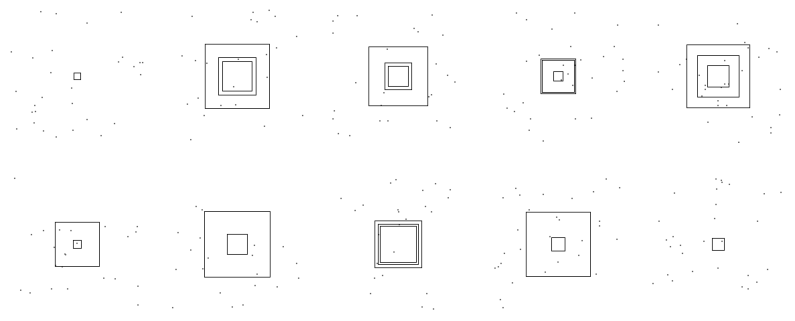

Test square data


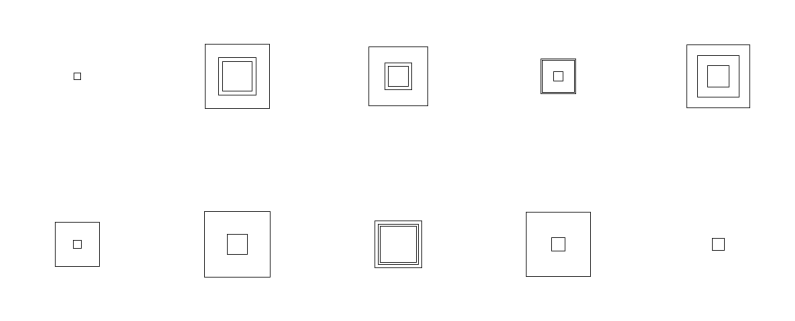

Predicted square


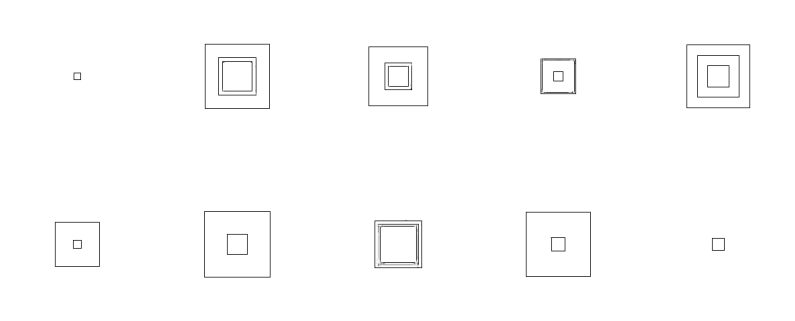

In [ ]:
# Visualize and save some of the separated images
print('Initial combined data')
Plot(test_dataset_combined_norm, 10, None)
print('Test square data')
Plot(test_dataset_squares_normalized, 10, None)
print('Predicted square')
Plot(predicted, 10, None)

test_dataset_combined_norm:  (1000, 200, 200)
test_dataset_squares_normalized:  (1000, 200, 200)
predicted:  (1000, 200, 200, 1)
predicted_squeezed:  (1000, 200, 200)

Print the final images = combined - predicted
max: 1.0 min: 0.0 non-zeros: 39960
max: 1.0 min: 3.145608502563846e-07 non-zeros: 40000
max: 1.0 min: 0.0 non-zeros: 39999
Initial combined data


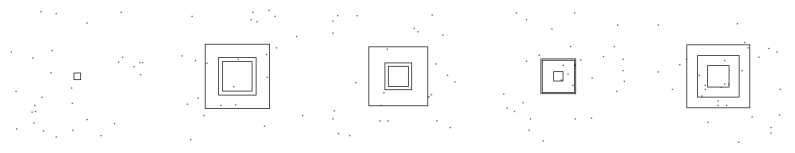

Test square data


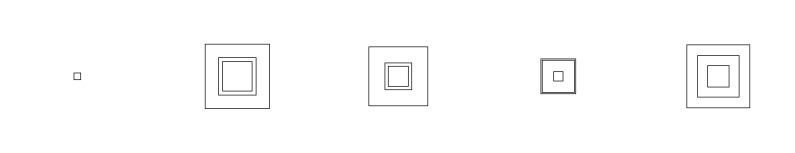

Predicated square data


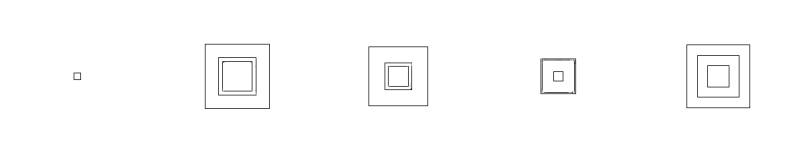

Predicated dot data


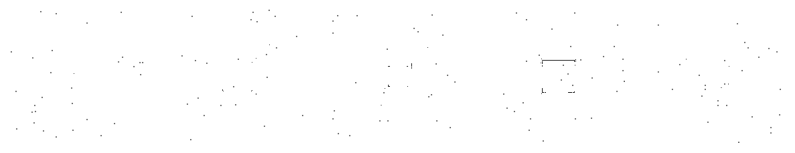

In [ ]:
# Separate the square and dot images from the images_overaly for 200x200 images
print("test_dataset_combined_norm: ", test_dataset_combined_norm.shape)
print("test_dataset_squares_normalized: ", test_dataset_squares_normalized.shape)
# print("test_dataset_rings_normalized: ", test_dataset_rings_normalized.shape)
print("predicted: ", predicted.shape) # shape (200, 200, 200, 1)
# Use np.squeeze to remove single-dimensional entries from the shape
predicted_squeezed = np.squeeze(predicted)
#predicted_squeezed = test_dataset_rings_normalized
# Now 'predicted_squeezed' should have the shape (200, 200, 200), the same as 'test_dataset_combined_norm'
print("predicted_squeezed: ", predicted_squeezed.shape)

# Separate the ring and dot images from the simulated test_dataset_combined_norm
#simulated_images_decoded = test_dataset_combined_norm - predicted_squeezed
# Convert to boolean where True indicates that pixels are the same
similar_pixels = np.isclose(test_dataset_combined_norm, predicted_squeezed, atol=0.05)  # atol is the tolerance level
# Invert the mask to get where the pixels differ
dots_mask = np.logical_not(similar_pixels)
# Use the mask to select the dots from either image
simulated_images_decoded = np.where(dots_mask, test_dataset_combined_norm, 1)  # Replace non-dot areas with white
#print("simulated_images_decoded: ", simulated_images_decoded.shape)

print(f"\nPrint the final images = combined - predicted")
#print(f"test_dataset_combined_norm[0]: {test_dataset_combined_norm[0]}")
print(f"max: {np.max(test_dataset_combined_norm[0])} min: {np.min(test_dataset_combined_norm[0])} non-zeros: {np.count_nonzero(test_dataset_combined_norm[0])}")
#print(f"predicted_squeezed[0]: {predicted_squeezed[0]}")
print(f"max: {np.max(predicted_squeezed[0])} min: {np.min(predicted_squeezed[0])} non-zeros: {np.count_nonzero(predicted_squeezed[0])}")
#print(f"simulated_images_decoded[0]: {simulated_images_decoded[0]}")
print(f"max: {np.max(simulated_images_decoded[0])} min: {np.min(simulated_images_decoded[0])} non-zeros: {np.count_nonzero(simulated_images_decoded[0])}")

print('Initial combined data')
Plot(test_dataset_combined_norm, 5, None)
print('Test square data')
Plot(test_dataset_squares_normalized, 5, None)
# Plot(test_dataset_rings_normalized, 5, None)
print('Predicated square data')
Plot(predicted, 5, None)
print('Predicated dot data')
Plot(simulated_images_decoded, 5, None)

200x200 with 50 epochs, batch size = 10, ran for > 1 hour
Epoch 50/50

100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 779ms/step - loss: 5.1400e-04 - val_loss: 5.9829e-04

200x200 with 20 epochs, batch size = 10
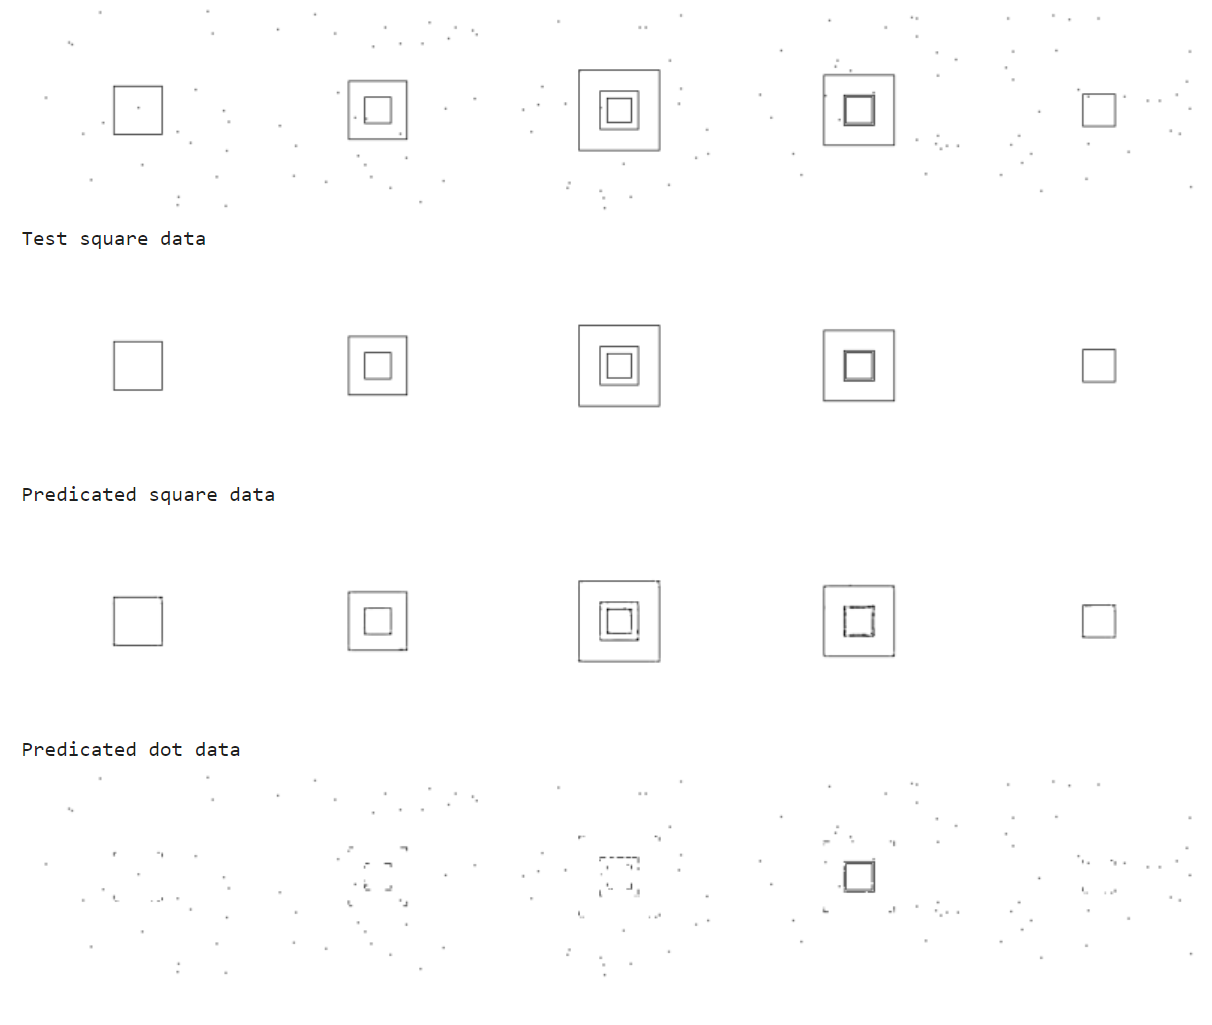

In [ ]:
# Separate the square and dot images from the images_overaly for 800x800 images
print("test_dataset_combined_norm: ", test_dataset_combined_norm.shape)
print("test_dataset_squares_normalized: ", test_dataset_squares_normalized.shape)
# print("test_dataset_rings_normalized: ", test_dataset_rings_normalized.shape)
print("predicted: ", predicted.shape) # shape (1000, 800, 800, 1)
# Use np.squeeze to remove single-dimensional entries from the shape
predicted_squeezed = np.squeeze(predicted)
#predicted_squeezed = test_dataset_rings_normalized
# Now 'predicted_squeezed' should have the shape (1000, 800, 800), the same as 'test_dataset_combined_norm'
print("predicted_squeezed: ", predicted_squeezed.shape)

# Separate the ring and dot images from the simulated test_dataset_combined_norm
#simulated_images_decoded = test_dataset_combined_norm - predicted_squeezed
# Convert to boolean where True indicates that pixels are the same
similar_pixels = np.isclose(test_dataset_combined_norm, predicted_squeezed, atol=0.05)  # atol is the tolerance level
# Invert the mask to get where the pixels differ
dots_mask = np.logical_not(similar_pixels)
# Use the mask to select the dots from either image
simulated_images_decoded = np.where(dots_mask, test_dataset_combined_norm, 1)  # Replace non-dot areas with white
#print("simulated_images_decoded: ", simulated_images_decoded.shape)

print(f"\nPrint the final images = combined - predicted")
#print(f"test_dataset_combined_norm[0]: {test_dataset_combined_norm[0]}")
print(f"max: {np.max(test_dataset_combined_norm[0])} min: {np.min(test_dataset_combined_norm[0])} non-zeros: {np.count_nonzero(test_dataset_combined_norm[0])}")
#print(f"predicted_squeezed[0]: {predicted_squeezed[0]}")
print(f"max: {np.max(predicted_squeezed[0])} min: {np.min(predicted_squeezed[0])} non-zeros: {np.count_nonzero(predicted_squeezed[0])}")
#print(f"simulated_images_decoded[0]: {simulated_images_decoded[0]}")
print(f"max: {np.max(simulated_images_decoded[0])} min: {np.min(simulated_images_decoded[0])} non-zeros: {np.count_nonzero(simulated_images_decoded[0])}")

print('Initial combined data')
Plot(test_dataset_combined_norm, 5, None)
print('Test square data')
Plot(test_dataset_squares_normalized, 5, None)
# Plot(test_dataset_rings_normalized, 5, None)
print('Predicated square data')
Plot(predicted, 5, None)
print('Predicated dot data')
Plot(simulated_images_decoded, 5, None)